# CSCI 347 Final Project - Wine Quality Classification

*   Timothy Bender
*   CSCI 347 - Final Project
*   April 11, 2021

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

file = 'winequality-red.csv'
data = pd.read_csv(file)

# Data Exploration

**Our dataset has approximately 1600 instances with 12 attributes. The first 11 attributes are float types, with the 12th attribute being the quality measured on a 1-10 integer scale. For the purpose of this project we will likely perform categorical standardization on the quality attribute at a later date.** 

In [3]:
print(data.shape)
print(data.head)
data.info()

(1599, 12)
<bound method NDFrame.head of       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6  

**Lets check for null values.**


In [4]:
print(data.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


**Since we have no null data instances we can begin our data exploration with a seaborn pairplot of our attributes.** 

In [5]:
pairplot = sns.pairplot(data, hue='quality')
pairplot.savefig('pairplot.png')

**Some of our attributes appear to have a high correlation, lets confirm this visually with a seaborne heatmap.** 

<AxesSubplot:>

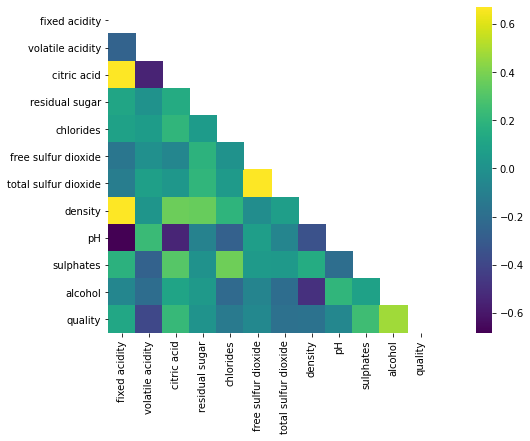

In [6]:
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15,6))
sns.heatmap(data.corr(), cmap = 'viridis', mask=mask, annot=False, square=True)

**It appears that the quality and alcohol have a relatively strong correlation,Lets explore that with a simple scatterplot.**

Text(0, 0.5, 'Alcohol')

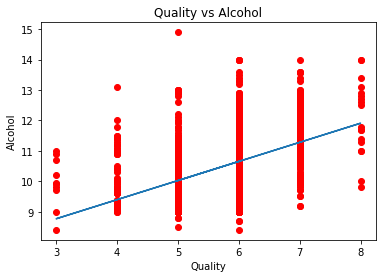

In [7]:
quality = data['quality']
alcohol = data['alcohol']

# I will also plot a line of best fit to better see the correlation
m, b = np.polyfit(quality, alcohol, 1)
plt.scatter(quality, alcohol, c='red')
plt.plot(quality, m*quality + b)

plt.title('Quality vs Alcohol')
plt.xlabel('Quality')
plt.ylabel('Alcohol')

**As expected we can see a steady rise in the quality of the wine as the alcohol level increases. Lets now plot the correlation between some of the other high correlated attribbutes. Namely fixed acidity, density, citric acid, and residual sugar.**

In [8]:
(abs(data.corr()[['fixed acidity', 'density', 'citric acid', 'residual sugar']])> .6) * 1


,fixed acidity,density,citric acid,residual sugar
fixed acidity,1,1,1,0
volatile acidity,0,0,0,0
citric acid,1,0,1,0
residual sugar,0,0,0,1
chlorides,0,0,0,0
free sulfur dioxide,0,0,0,0
total sulfur dioxide,0,0,0,0
density,1,1,0,0
pH,1,0,0,0
sulphates,0,0,0,0


**Based on this table I can see that Fixed acidity has a high correlation to citric acid, density, and the pH level. Unexpectedly residual sugar seems to have no high correlation between any of the other attributes.** 

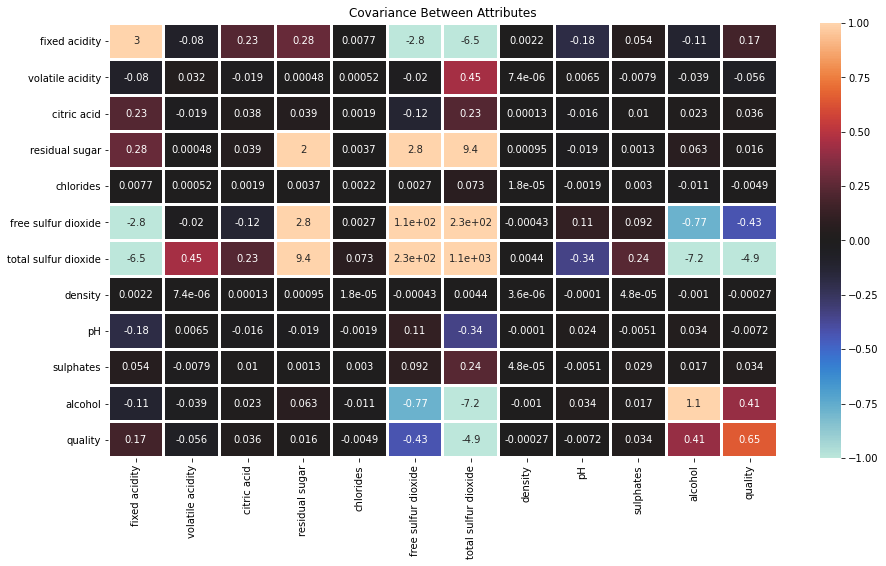

In [9]:
covariance = data.cov()
figure = plt.figure(figsize=(15,8))
sns.heatmap(covariance,annot=True,vmin=-1,center=0,vmax=1,linewidths=2)
plt.title("Covariance Between Attributes")
plt.show()

Text(0.5, 0, 'Clusters')

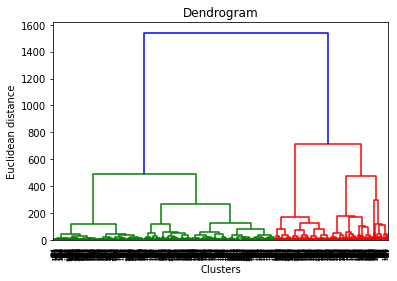

In [24]:
# Lets use a dendrogram to determine the clustering possibilities for this data. 
import scipy.cluster.hierarchy as sch
dendro = sch.dendrogram(sch.linkage(data,method='ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.xlabel('Clusters')

It seems that our data could be split into two primary clusters, 
this will support my later decision to experiment with the RandomForestclassifier

Text(0.5, 1.0, 'Quality')

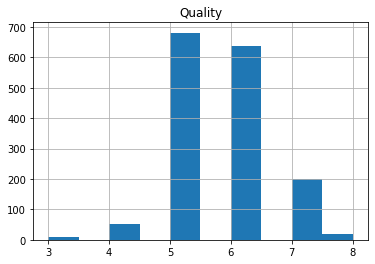

In [25]:
data['quality'].hist()
plt.title('Quality')


**Our quality seems to have a very low variance and clusters around the 5-7 range, this extremely biased data will likely hurt the training model in the long term. A more varied dataset with different qualities of wine would be preferred for a more general model.**

# Data Preparation


**As is displayed above the quality of wine has extremely high groupings around 5,6, and 7. For our purposes, a wine classifier we will consider any wine with a score of 7 or above a "good" wine, and anything below that a "bad" wine. I will also attempt to remove any outliers by calculating the z score of each attribute and removing outliers.** 


In [54]:
from scipy import stats
data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

**With our data cleaned of any outliers, we may now sort the wine quality into its appropriate categories. Again any wine with a score of 7 or higher will be considered a good wine.** 

In [ ]:
X = data.loc[:, data.columns != 'quality'].values
y = data.quality.values
y = data['quality'].apply(lambda y_data: 1 if y_data>=7 else 0)
from scipy import stats

**With our data prepared we can now split the data into training and test data.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=3)

# Creation of the Tensforflow Model

In [55]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

**Our Keras model will feature 5 Dense layers, the first 4 will have decreasing numbers of neurons and use the relu activation function. Since we are attempting to categorically map to a value between 0 and 1, we will use the sigmoid activation function on the final decision neuron. The tanh activation function could have also been used.**

**When compiling the model, we will use the typical adam optimizer, with categorical_crossentropy for our loss function. In addition we will track the accuracy metric to evaluate our model later.** 

In [56]:
ben_init = tf.keras.initializers.GlorotNormal()

model = Sequential()
model.add(Dense(48, kernel_initializer=ben_init,  activation='relu'))
model.add(Dense(24, kernel_initializer=ben_init, activation='relu'))
model.add(Dense(12, kernel_initializer=ben_init, activation='relu'))
model.add(Dense(6, kernel_initializer=ben_init,
activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**With our model created we will now train our model on our training dataset, and validate it against our test data.** 

In [57]:
model.fit(X_train, y_train, epochs=300,validation_data=(X_test, y_test), verbose=0)

**Our model seems to have performed decently well, with an accuracy of 89%. A more fine tuned model and a more robust dataset would likely be required to approach the 95%+ range of accuracy.**

In [58]:
losses = pd.DataFrame(model.history.history)

# losses[['loss','val_loss']].plot()
# losses[['accuracy','val_accuracy']].plot()

print(model.metrics_names)
print(model.evaluate(X_test,y_test,verbose=0))

['loss', 'accuracy']
[0.0, 0.8916666507720947]


# Random Forest Classifier

**Based on the results of my dendrogram above, I believe a random forest classifier would work well for this dataset. Let's explore the accuracy of such a model and compare it to the accuracy of my Keras model.** 

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

In [60]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
pred = forest.predict(X_test)
print('Accuracy for Random Forest Classification: ', accuracy_score(y_test, pred))

Accuracy for Random Forest Classification:  0.925


**Surprisingly the random forest classification model attained a marginally higher accuracy than the Keras model.** 